<**데이터 load**>

In [ ]:
import pandas as pd

In [ ]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [ ]:
train_data = pd.read_table("nsmc/ratings_train.txt")
test_data = pd.read_table("nsmc/ratings_test.txt")

In [ ]:
# 데이터(리뷰) 개수 확인
print('train data 개수: ', len(train_data))
print('test data 개수: ', len(test_data))

train data 개수:  150000
test data 개수:  50000


In [ ]:
# train data 형태 확인

train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


[Columns of the dataset]

학습 데이터에서 상위 5개의 리뷰를 출력해봄으로써, 데이터의 형태를 확인할 수 있다. NSMC 데이터셋은 3개의 feature, 혹은 column으로 이뤄져있는데 각가 id, document, label이다. 
- id: 각 리뷰에 부여한 인식표임으로 감정 분석(분류)에서는 유용한 column이 아니다. 
- document: 리뷰 내용에 해당하며, 데이터 셋 정보에 따르면 각 리뷰는 140자 미만이다. "..." 등의 불용어를 제거해야할 필요성을 확인할 수 있다.
- label: 해당 데이터는 labeled 데이터임을 알 수 있다. 긍정의 리뷰의 경우 1, 부정의 리뷰의 경우 0의 값이 각 데이터 당 부여되어 있다.

=> 결국, NSMC 데이터셋을 이용한 감정 분석 프로젝트는 document와 label 2개의 열을 학습하는 모델을 구축하는 것임을 알 수 있다.

[Information from the dataset]

- 한국어 데이터의 특성: 띄어쓰기가 제대로 되어 있지 않은 데이터가 존재한다.
=> 처리 필요!

In [ ]:
# test data 형태 확인

test_data[:5] # 상위 5개 출력

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


Test 데이터도 train 데이터와 마찬가지의 3개의 열로 이뤄져있으며, 리뷰에 해당하는 document 역시 전처리가 필요함을 확인할 수 있다. 이 전처리는, train 데이터에 대한 전처리 과정을 동일하게 적용시키면 된다.

<**데이터 정제/전처리**>

In [ ]:
# train data의 중복 확인하기
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

학습 데이터의 중복을 확인하는 과정에서, document 즉, 리뷰에서 중복을 제거한 데이터의 개수가 약 14만 6천개라는 것은 약 4천개의 데이터가 중복되어 있다는 의미이다. label 열에 대해서는 0과 1만 존재하므로 2라는 값이 출력된 것이다.

In [ ]:
# train data의 중복 제거하기 - document 열에서 중복 내용 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
# train data의 중복 확인
print('학습 데이터의 총 샘플의 개수: ', len(train_data))

학습 데이터의 총 샘플의 개수:  146183


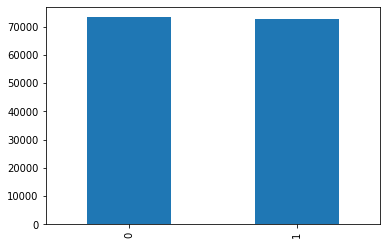

In [ ]:
# 중복을 제거한 train data의 긍정/부정 label 값의 분포 확인
train_data['label'].value_counts().plot(kind='bar')

In [ ]:
# 중복을 제거한 train data의 긍정/부정 lable 값의 정확한 개수 확인
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


[학습 데이터의 중복 documents를 제거한 후, label의 분포]

약 146000개의 학습 데이터에서 긍정과 부정의 label의 분포가 균일해보이고, 정확한 개수를 파악해본 결과 label=0의 데이터가 근소하게 많은 것을 확인할 수 있다.

In [ ]:
# 학습 데이터 중 NULL 값 존재 여부 확인하기
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


[학습 데이터에서, NULL 값 확인 결과]

id와 label은 NULL인 데이터가 없지만, document에 NULL인 데이터가 하나 존재한다는 것을 확인하였다. 본 프로젝트는 document와 label을 학습하는 것인데, document에 NULL 값이 존재하면 학습할 데이터가 없는 것이므로, NULL이 포함된 해당 데이터를 삭제하겠다.

In [ ]:
# 학습 데이터에서 NULL 포함 데이터 행 삭제
train_data = train_data.dropna(how='any') # 삭제
print(train_data.isnull().values.any()) # 삭제 후, NULL 값이 존재하는 지 확인

False


- 현재까지 NSMC 데이터의 분포를 확인해보고, 학습 데이터를 전처리하게 전에 NULL 값이 포함된 데이터를 제거하였다.

In [ ]:
# 위에서 데이터를 출력해봄으로써, 학습과 관련 없는 특수 문자 및 기호를 제거한다
# -> 한글 텍스트만 남김
# 정규 표현식을 활용하여 한글의 범위 지정: 자음의 범위(ㄱ-ㅎ), 모음의 범위(ㅏ-ㅣ)
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
# 한글과 공백을 제외하고 모두 제거

In [ ]:
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- 전처리 전에 출력한 데이터와 비교해서 기존의 공백과 띄워쓰기는 유지되면서 구두점과 기호는 제거되었음을 확인할 수 있다.
- 여기서 또 다른 전처리의 필요성이 대두된다!
  * 왜냐하면, 네이버 영화 리뷰는 특수 기호나 영어 등 한글과 공백 이외의 문자만으로도 작성이 가능한데 이런 document들은 위의 전처리를 통해 NULL 값이 되었을 것이기 때문이다

In [ ]:
import numpy as np

In [ ]:
# 한글과 공백만 남기는 전처리 이후 NULL 값의 존재 여부 확인
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


- 첫번째 전처리 후, NULL 값으로 바뀐 document 데이터가 391개나 생겼음을 알 수 있다. document feature를 통해서 학습을 해하고, label과 다르게 평균 혹은 수동 imputing이 불가능함으로 의미 없는 데이터로 판정하고 제거한다.

In [ ]:
# NULL 값을 포함한 학습 데이터 삭제
train_data = train_data.dropna(how = 'any')
print(len(train_data))

146182


* 지금까지 학습 데이터에 수행한

  - document 열에서의 중복 제거
  - 한글 범위와 공백에 벗어나는 데이터 제거
  - NULL 값 제거

  => 3 가지의 일련의 전처리 과정을 테스트 데이터에도 동일하게 진행한다.


In [ ]:
# document 열에서 중복 제거
test_data.drop_duplicates(subset = ['document'], inplace=True)
# 정규 표현식으로 한글 범위와 공백 이외의 문자 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 공백을 NULL 값으로 변경 후 NULL 값 제거
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')

In [ ]:
# 전처리 후 테스트 데이터의 개수 확인
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


**<토큰화>**

- 토큰화 과정에서는 불용어 제거를 첫번째 목표로 한다.
- 불용어는 조사와 접속사를 우선 의미하며, 지속적으로 데이터를 검토하면서 처리할 계획이다.

In [ ]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

>> 불용어 정의를 더 확장해볼 수 있을 것 같다!!!

In [ ]:
# 토큰화를 위한 형태소 분석기로 KoNLPy의 Okt를 사용하기로 한다
# 한국어 토큰화는 영어처럼 띄어쓰기 기준을 적용하지 않고 형태소 분석기를 적용한다
!pip3 install konlpy

     |████████████████████████████████| 19.4MB 9.7MB/s 
     |████████████████████████████████| 460kB 49.3MB/s 
     |████████████████████████████████| 92kB 11.4MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [ ]:
from konlpy.tag import Okt

>> 형태소 분석기 간의 성능 차이를 살펴봐도 좋을 것 같다!!!

In [ ]:
okt = Okt() # konlpy에서 제공하는 형태소 분석기
# train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장한다
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화, stemp=True는 일정 수준의 정규화를 수행해준다
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [ ]:
# 상위 3개의 데이터만 출력하여 결과 확인하기
print(X_train[:3])

- 토큰화를 진행하고 불용어를 제거함으로써, 어느 정도의 정규화가 이뤄진 형태소로 tokenize 된 것을 볼 수 있다.

In [ ]:
# test 데이터에 대해서도 동일하게 토큰화 진행
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

* 지금까지 train_data와 test_data에 대해서 텍스트 전처리를 수행해 보았다.

**<정수 인코딩>**

- machine이 한글 텍스트를 숫자로 처리하여 학습할 수 있도록, 
훈련 데이터와 테스트 데이터를 정수로 인코딩을 해야한다.

In [ ]:
# train 데이터에 대해서 단어 집합 만들기
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(X_train)

In [ ]:
# 단어 집합이 생성되고, 각 단어에 고유한 정수가 부여된 것을 확인하기
print(tokenizer.word_index)

- 단어가 4만 3천여개가 넘개 존재하는데, 이때 각 단어에 부여된 정수는 전체 train 데이터에서 빈도수가 높은 순서대로 부여되었다.
- 빈도수를 반영하기 위해서, 빈도수가 낮은 단어들이 이 데이터에서 차지하는 비중을 확인하고 자연어 처리에서 배제하고자 한다.
* 여기서의 가정: 빈도수가 매우 낮은 단어들은 감정 분석에 중요한 학습 요소가 아니다!

In [ ]:
# 빈도수 하한선을 3회로 잡고, 빈도수가 3회 미만인 단어들의 비중 확인해보기
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [ ]:
# 단어와 빈도수 쌍을 key와 value로 받기
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

* 위의 분석을 통해서, 등장 빈도가 3회 미만인 단어들에 대한 통계를 확인할 수 있다.
  - 등장 빈도가 3회 미만인 단어들을 이하 희귀 단어로 칭한다.
  - 희귀 단어들이 단어 집합에서 차지하는 비중은 절반 이상이다.
  - 하지만, 실제로 train 데이터에서 등장 빈도로 차지하는 비중은 1.87% 정도로 매우 적다.

  => 따라서, 위의 희귀 단어들을 정수 인코딩 과정에서 배제시키고, 희귀 단어들을 제외한 단어 개수를 단어 집합의 최대 크기로 제한한다.

  >> 빈도수 threshold를 변화시켜가면서 포함할 단어의 범위를 조정해볼 수 있을 것 같다!!!

In [ ]:
# 전체 단어 개수 중 빈도수 3 미만인 단어 개수는 제거
# 0번 패딩 토큰을 고려하여 +1한다
vocab_size = total_cnt - rare_cnt + 1 
print('단어 집합의 크기 :',vocab_size)

In [ ]:
# Keras의 tokenizer에 단어 집합의 크기를 인자로 넘겨주기
# -> 텍스트 sequence를 정수 sequence로 변환하는 인코딩 과정에서
#    인자보다 큰 숫자가 부여된 단어들은 제외시킨다
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# 정수 인코딩의 결과 확인을 위해 3개의 데이터 출력해보기
print(X_train[:3])

- 각 데이터의 단어들이 해당하는 정수로 변환된 것을 볼 수 있다.
* 단어의 개수는 19416개로 인자를 통해 제한되었으므로, 0번 단어에서부터 19415번 단어까지만 사용함을 의미한다.
  - 0번 단어는 패딩을 위한 토큰이다.
  - 19416 이상의 숫자는 train 데이터에 더이상 존재하지 않음을 의미한다.

In [ ]:
# train_data 별도 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

**<empty 샘플 제거>**

* 전체 데이터에서 빈도수가 낮은 희귀 단어를 삭제했다
* -> 이는 빈도수가 낮은 단어들로만 구성된 샘픋들이 empty해졌다는 것을 의미한다!
* empty 샘플들은 label이 어떤 값이든 학습에 사용할 수 없는 의미 없는 데이터이므로 제거해주는 작업을 거쳐야한다.

In [ ]:
# 각 샘플들의 길이를 확인해서, 길이가 0인 empty 샘플들의 인덱스 받아오기
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [ ]:
# drop_train에는 X_train의 empty 샘플들의 인덱스가 저장됨
# drop_test에는 X_test의 empty 샘플들의 인덱스가 저장됨
# empty 샘플 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

- 이전의 train 데이터 (X_train과 y_train_)의 데이터 개수는 145791개 였는데, empty 샘플의 제거를 통해서 샘플의 개수가 줄어든 것을 확은할 수 있다.
- test 데이터에 대해서도 빈 값을 동일한 과정을 통해 제거해준다.

In [ ]:
# test 데이터의 empty 샘플 제거하기
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

<**패딩**>

- 서로 길이가 다른 샘플들의 길이를 동일하게 맞춰주는 작업: 패딩 작업

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포 파악하기
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 리뷰의 최대 길이는 69이다
- 전체 데이터의 길이 분포는 평균 길이 값인 10 내외이다.
* 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플 길이를 동일하게 맞춰줘야한다
* -> 특정 길이를 정해야한다!
  - 특정 길이 변수를 max_len으로 정하고 대부분의 리뷰가 잘리지 않도록 하는 최적의 변수 값을 찾아낸다.
    -  전체 샘플들 중에서 길이가 max_len 이하인 샘플의 비율을 확인함으로써 가능하다.

In [ ]:
# 전체 샘플 중에서 길이가 max_len 이하인 샘플의 비율을 확인하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
# 전체 길이 분포 그래프에서 max_len = 30을 상정하여, 비율을 확인하기
max_len = 30
below_threshold_len(max_len, X_train)

- 함수를 통해서 전체 train 데이터 중 약 94%의 리뷰가 30 이하의 길이를 가지는 것을 확인했다
- 모든 샘플의 길이를 30으로 맞추겠다.

>> max_len을 조정하면서 패딩에 변화를 주고 결과 변화를 볼 수 있을 것 같다!!!

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

**<LSTM으로 감성 분류>**

In [ ]:
# 모델 구축을 위해 필요한 도구 import
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

>임베딩 벡터의 차원을 100으로 정했는데, 임베딩 벡터의 차원 공부하기!

> LSTM(128)에서 128 인자의 역할 공부하기!

>> activation 함수를 바꿔보는 것이 어떤 영향을 줄 지 공부하기!

* 학습 과정에서 검증 데이터 손실 (val_loss)가 다시 증가하면, overfit의 징후이므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료하여 효율적인 학습을 시도해았다.
* ModelCheckpoint를 활용해서 검증 데이터의 정확도 (val_acc)가 이전보다 좋아질 경우에만 모델을 저장한다

>> val_loss 증가 인자를 조정해볼 수 있다!!!

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [48]:
# 에포크를 총 15번 수행함
# train 데이터 중 20%를 검증 데이터로 사용하면서 정확도를 확인함
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1936/1936 [==============================] - 31s 12ms/step - loss: 0.4388 - acc: 0.7913 - val_loss: 0.3527 - val_acc: 0.8445

Epoch 00001: val_acc improved from -inf to 0.84454, saving model to best_model.h5
Epoch 2/15
1936/1936 [==============================] - 22s 11ms/step - loss: 0.3308 - acc: 0.8564 - val_loss: 0.3342 - val_acc: 0.8554

Epoch 00002: val_acc improved from 0.84454 to 0.85542, saving model to best_model.h5
Epoch 3/15
1936/1936 [==============================] - 22s 11ms/step - loss: 0.3027 - acc: 0.8706 - val_loss: 0.3290 - val_acc: 0.8593

Epoch 00003: val_acc improved from 0.85542 to 0.85928, saving model to best_model.h5
Epoch 4/15
1936/1936 [==============================] - 22s 11ms/step - loss: 0.2813 - acc: 0.8829 - val_loss: 0.3273 - val_acc: 0.8586

Epoch 00004: val_acc did not improve from 0.85928
Epoch 5/15
1936/1936 [==============================] - 22s 11ms/step - loss: 0.2611 - acc: 0.8932 - val_loss: 0.3285 - val_acc: 0.8583

Epoch 00005: 

>> epoch나 검증 데이터 비율을 조정해본다!!!

- 조기 종료 조건에 따라서 7번째 epoch에서 학습이 종료되었다.
- test 데이터로 정확도를 측정할 때는, 위의 학습 과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 best_model.h5를 사용한다!

In [49]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1524/1524 [==============================] - 5s 3ms/step - loss: 0.3369 - acc: 0.8562

 테스트 정확도: 0.8562

 테스트 정확도: 0.8562


<소스 코드 참고>
https://wikidocs.net/44249
